<a href="https://colab.research.google.com/github/TimurMMD/AI_LSBF-UEL_project/blob/main/CNN_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/My Drive/AI&MV'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'seg_train/seg_train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'seg_test/seg_test'), transform=transform)
#test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'seg_pred'), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Define the dataset class
class IntelImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {
            'buildings': 0,
            'forest': 1,
            'glacier': 2,
            'mountain': 3,
            'sea': 4,
            'street': 5
        }
        self.load_data()

    def load_data(self):
        for label in self.label_map:
            img_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(img_dir):
                img_path = os.path.join(img_dir, img_name)
                self.images.append(img_path)
                self.labels.append(self.label_map[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load the dataset
data_dir = '/content/drive/My Drive/AI&MV/seg_train/seg_train'
train_dataset = IntelImageDataset(data_dir=data_dir, transform=transform)

data_dir = '/content/drive/MyDrive/AI&MV/seg_test/seg_test'
val_dataset = IntelImageDataset(data_dir=data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
# Define the CNN model
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.features = models.resnet18(pretrained=True)
        self.features.fc = nn.Linear(self.features.fc.in_features, 1)  # Change the output layer for regression

    def forward(self, x):
        x = self.features(x)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNRegression().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [8]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 3.0881, Validation Loss: 2.8343
Epoch [2/10], Training Loss: 2.3211, Validation Loss: 2.1538
Epoch [3/10], Training Loss: 1.9150, Validation Loss: 1.7544
Epoch [4/10], Training Loss: 1.7093, Validation Loss: 2.9047
Epoch [5/10], Training Loss: 1.4721, Validation Loss: 1.4428
Epoch [6/10], Training Loss: 1.3906, Validation Loss: 1.8257
Epoch [7/10], Training Loss: 1.2829, Validation Loss: 1.3582
Epoch [8/10], Training Loss: 1.2322, Validation Loss: 4.8594
Epoch [9/10], Training Loss: 1.1050, Validation Loss: 1.3672
Epoch [10/10], Training Loss: 0.9948, Validation Loss: 1.6528


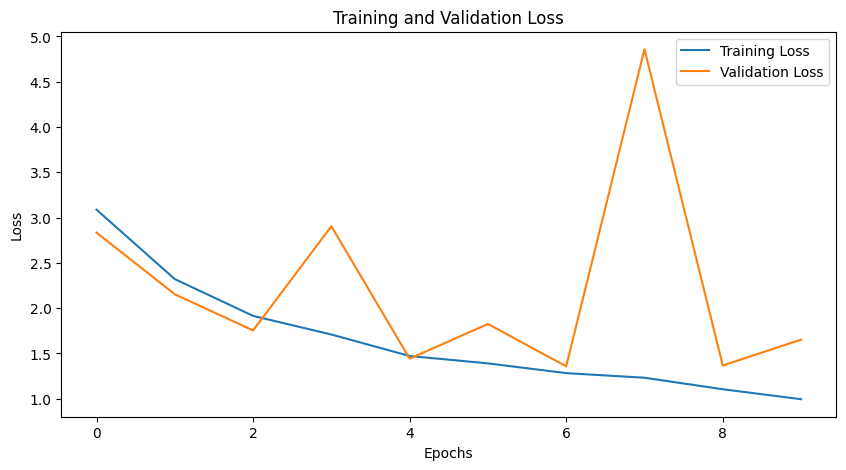

In [9]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
# Saving the model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_regression_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/model_regression_cnn.pth
